# Imports

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

%matplotlib inline


---

# Utilities


In [2]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images
    # and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


---

# 1. Data Acquisition


In [3]:
x_train = []    # The images of the training dataset
y_train = []    # The correct label of each image of the training dataset
z_train = []    # The name of each image of the training dataset (for debugging purposes)


In [4]:
# Male data acquisition
for file_name in sorted(glob.glob('../Training Dataset/CMP_23/Males/*.jpg')):
    img = cv2.imread(file_name)      # cv2.imread reads images in RGB format
    x_train.append(img)
    y_train.append(1)
    z_train.append(file_name)


In [5]:
# Female data acquisition
for file_name in sorted(glob.glob('../Training Dataset/CMP_23/Females/*.jpg')):
    img = cv2.imread(file_name)      # cv2.imread reads images in RGB format
    x_train.append(img)
    y_train.append(0)
    z_train.append(file_name)


In [6]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
z_train = np.asarray(z_train)
print(f"Size of the training dataset is: {x_train.shape[0]} ({np.sum(y_train)} males, {x_train.shape[0] - np.sum(y_train)} females)")


Size of the training dataset is: 363 (232 males, 131 females)


C:\Users\mosel\AppData\Local\Temp\ipykernel_13272\163425456.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.asarray(x_train)


---

# 2. Data Preprocessing


In [7]:
def preprocess_image(image: np.ndarray, sharpness_factor=10, bordersize=3):
    image = Image.fromarray(image)
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(sharpness_factor)

    (height, width) = (image.height * 2, image.width * 2)
    image = image.resize((width, height))

    image = np.asarray(image)
    image = cv2.copyMakeBorder(
        image,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    (_, preprocessed_image) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    return preprocessed_image


In [8]:
for i in range(len(x_train)):
    x_train[i] = preprocess_image(x_train[i])


---

# 3. Feature Extraction


### A) Hinge Feature Extraction


In [9]:
N_ANGLE_BINS = 40
BIN_SIZE = 360 // N_ANGLE_BINS
LEG_LENGTH = 25

In [10]:
def get_contour_pixels(preprocessed_image: np.ndarray):
    contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]

    image2 = preprocessed_image.copy()[:, :, np.newaxis]
    image2 = np.concatenate([image2, image2, image2], axis=2)
    return contours


In [11]:
def get_hinge_features(preprocessed_image: np.ndarray):
    contours = get_contour_pixels(preprocessed_image)

    hist = np.zeros((N_ANGLE_BINS, N_ANGLE_BINS))

    for cnt in contours:
        n_pixels = len(cnt)
        if n_pixels <= LEG_LENGTH:
            continue

        points = np.array([point[0] for point in cnt])
        (xs, ys) = (points[:, 0], points[:, 1])
        point_1s = np.array([cnt[(i + LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
        point_2s = np.array([cnt[(i - LEG_LENGTH) % n_pixels][0] for i in range(n_pixels)])
        (x1s, y1s) = (point_1s[:, 0], point_1s[:, 1])
        (x2s, y2s) = (point_2s[:, 0], point_2s[:, 1])

        phi_1s = np.degrees(np.arctan2(y1s - ys, x1s - xs) + np.pi)
        phi_2s = np.degrees(np.arctan2(y2s - ys, x2s - xs) + np.pi)

        indices = np.where(phi_2s > phi_1s)[0]

        for i in indices:
            phi1 = int(phi_1s[i] // BIN_SIZE) % N_ANGLE_BINS
            phi2 = int(phi_2s[i] // BIN_SIZE) % N_ANGLE_BINS
            hist[phi1, phi2] += 1

    normalized_hist = hist / np.sum(hist)
    feature_vector = normalized_hist[np.triu_indices_from(normalized_hist, k=1)]

    return feature_vector


In [12]:
hinge_feature_vector = []
for i in range(len(x_train)):
    hinge_feature_vector.append(get_hinge_features(x_train[i]))
hinge_feature_vector = np.asarray(hinge_feature_vector)

(363, 780)
<class 'numpy.ndarray'>


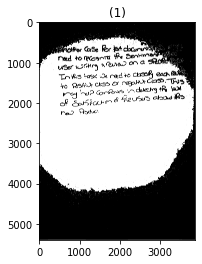

In [23]:
print(hinge_feature_vector.shape)
print(type(hinge_feature_vector[0]))

---

# 4. Machine Learning Model


---

# 5. Model Accuracy
